# HELICS Fundamentals

## Overview

This lesson introduces the core concepts of HELICS (Hierarchical Engine for Large-scale Infrastructure Co-Simulation), building directly on the installation completed in the previous lesson. We will progress from fundamental concepts to hands-on implementation of simple co-simulation federates.

## Learning Objectives

By the end of this lesson, students will be able to:

1. Explain the purpose and architecture of HELICS co-simulation
2. Understand the roles of brokers, federates, and the publication/subscription model
3. Identify the stages of co-simulation execution
4. Create and run simple two-federate co-simulations in Python
5. Configure federate communication using both API calls and JSON configuration
6. Debug basic co-simulation issues

## Prerequisites

- Completed Lesson 1 (Co-Simulation Environment Setup)
- Active `cosim` conda environment with HELICS installed
- Basic Python programming knowledge
- Understanding of simulation concepts

## Environment Verification

Before we begin, let's verify that our co-simulation environment is properly configured and HELICS is available.

In [1]:
# Verify HELICS installation and basic functionality
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

try:
    import helics as h
    print(f"✓ HELICS version: {h.helicsGetVersion()}")
    print(f"✓ Python version: {sys.version.split()[0]}")
    print(f"✓ Environment ready for co-simulation")
except ImportError as e:
    print(f"✗ HELICS import failed: {e}")
    print("Please ensure the 'cosim' conda environment is activated")
    print("Run: mamba activate cosim")
except OSError as e:
    if "undefined symbol" in str(e):
        print(f"✗ HELICS import failed with C++ library error: {e}")
        print("\nThis is a known issue with Jupyter environments.")
        print("Please see the troubleshooting section in setup.md:")
        print("  Section: 'HELICS Import Error in Jupyter'")
        print("\nQuick fix: Use the custom kernel 'CoSim (HELICS Fixed)' if available")
    else:
        raise

✓ HELICS version: 3.6.1 (2025-02-24)
✓ Python version: 3.9.23
✓ Environment ready for co-simulation


## Introduction: Why Co-Simulation?

### The Challenge of Complex Systems

Modern engineering systems are increasingly complex and interconnected. Consider these examples:

- **Smart Grids**: Electrical transmission systems interact with distribution networks, which connect to renewable energy sources, electric vehicles, and smart appliances
- **Smart Cities**: Transportation systems coordinate with energy networks, communication infrastructure, and building management systems
- **Industrial Systems**: Manufacturing processes integrate with supply chains, energy systems, and control networks

### Limitations of Traditional Simulation

Traditional simulation approaches face several limitations:

1. **Domain Expertise**: Different parts of complex systems require specialized modeling tools and domain knowledge
2. **Computational Complexity**: Modeling everything in one tool becomes computationally intractable
3. **Tool Optimization**: Specialized tools are optimized for specific domains and may not handle other domains well
4. **Development Cost**: Creating monolithic simulation tools for complex systems is expensive and time-consuming

### Co-Simulation Solution

Co-simulation addresses these challenges by:

- **Connecting Specialized Tools**: Each tool focuses on what it does best
- **Coordinated Execution**: Tools run simultaneously and exchange information
- **Time Synchronization**: Ensures all tools advance through time in a coordinated manner
- **Scalable Architecture**: Can accommodate from two to thousands of simulation tools

## Core HELICS Concepts

### The HELICS Architecture

HELICS provides a standardized framework for co-simulation with four key components:

#### 1. Broker
- **Definition**: Central coordination hub that manages communication between federates
- **Functionality**: Message routing, time synchronization, federation lifecycle management
- **Analogy**: Like a postal service that coordinates mail delivery between different addresses
- **Implementation**: Usually one broker per co-simulation, but can be hierarchical for large systems

#### 2. Federate
- **Definition**: An individual simulation or computational entity within the co-simulation
- **Types**: 
  - Value federates (continuous/physics-based simulations)
  - Message federates (discrete event simulations)
  - Combination federates (both value and message capabilities)
- **Characteristics**: Independent execution, specific time management, defined interfaces

#### 3. Publication/Subscription Model
- **Concept**: Decoupled communication where data producers and consumers don't directly interact
- **Publications**: Data outputs from a federate that other federates can access
- **Subscriptions**: Data inputs to a federate from other federates' publications
- **Benefits**: Scalability, modularity, flexibility in system design

#### 4. Time Management
- **Purpose**: Ensures all federates advance through simulation time in a coordinated manner
- **Implementation**: Federates request permission to advance to specific times
- **Coordination**: Broker grants time advancement only when it's safe for all federates

### Co-Simulation Execution Stages

Every HELICS co-simulation progresses through four distinct stages:

1. **Creation**: Register federates, define publications/subscriptions, establish communication interfaces
2. **Initialization**: Prepare for simulation, exchange initial data, verify connections
3. **Execution**: Main simulation loop with coordinated time advancement and data exchange
4. **Finalization**: Clean shutdown, disconnect federates, release resources

## First HELICS Program: Pi Exchange

We'll start with a simple example that demonstrates the core HELICS concepts: a federate that calculates pi using a Monte Carlo method and another federate that receives and displays the results.

### System Design

**Pi Calculator Federate:**
- Computes pi using Monte Carlo method (random points in circle vs square)
- Publishes pi estimates at regular intervals
- Improves accuracy over time by increasing sample size

**Pi Receiver Federate:**
- Subscribes to pi estimates from the calculator
- Displays received values and compares to true value
- Tracks improvement in accuracy over time

### Implementation Strategy

We'll implement both federates in the same notebook using Python threading to run them simultaneously.

In [2]:
# Import required libraries for the Pi exchange example
import threading
import time
import random
import math
from queue import Queue

# Verify threading capability
print("✓ Threading support available")
print("✓ Ready to implement Pi exchange example")

✓ Threading support available
✓ Ready to implement Pi exchange example


### Pi Calculator Federate Implementation

In [3]:
def pi_calculator_federate():
    """
    HELICS federate that calculates pi using Monte Carlo method
    and publishes results for other federates to consume
    """
    
    print("[Pi Calculator] Starting federate...")
    
    # Step 1: Create federate info object
    fedinfo = h.helicsCreateFederateInfo()
    
    # Step 2: Configure federate properties
    h.helicsFederateInfoSetCoreName(fedinfo, "PiCalculator")
    h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
    h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
    h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.01)
    
    # Step 3: Create the federate
    fed = h.helicsCreateValueFederate("PiCalculator", fedinfo)
    print("[Pi Calculator] ✓ Value federate created")
    
    # Step 4: Register publication
    pub = h.helicsFederateRegisterGlobalPublication(fed, "pi_estimate", h.HELICS_DATA_TYPE_DOUBLE, "")
    print("[Pi Calculator] ✓ Publication 'pi_estimate' registered")
    
    # Step 5: Enter execution mode
    print("[Pi Calculator] Entering execution mode...")
    h.helicsFederateEnterExecutingMode(fed)
    print("[Pi Calculator] ✓ Execution mode entered")
    
    # Step 6: Main simulation loop
    current_time = 0.0
    time_step = 1.0  # 1 second steps
    total_samples = 1000
    
    for step in range(10):  # Run for 10 time steps
        # Request permission to advance to next time
        next_time = (step + 1) * time_step
        current_time = h.helicsFederateRequestTime(fed, next_time)
        
        # Monte Carlo calculation of pi
        samples_in_circle = 0
        for _ in range(total_samples):
            x = random.uniform(-1, 1)
            y = random.uniform(-1, 1)
            if x*x + y*y <= 1:
                samples_in_circle += 1
        
        # Calculate pi estimate
        pi_estimate = 4 * samples_in_circle / total_samples
        error = abs(pi_estimate - math.pi)
        
        # Publish the result
        h.helicsPublicationPublishDouble(pub, pi_estimate)
        
        print(f"[Pi Calculator] Time {current_time:.1f}s: π ≈ {pi_estimate:.6f} (error: {error:.6f})")
        
        # Increase sample size for better accuracy
        total_samples += 500
    
    # Step 7: Finalize federate
    h.helicsFederateDestroy(fed)
    print("[Pi Calculator] ✓ Federate finalized")

### Pi Receiver Federate Implementation

In [4]:
def pi_receiver_federate(results_queue):
    """
    HELICS federate that receives pi estimates from calculator
    and analyzes the accuracy improvement over time
    """
    
    print("[Pi Receiver] Starting federate...")
    
    # Step 1: Create federate info object
    fedinfo = h.helicsCreateFederateInfo()
    
    # Step 2: Configure federate properties
    h.helicsFederateInfoSetCoreName(fedinfo, "PiReceiver")
    h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
    h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
    h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.01)
    
    # Step 3: Create the federate
    fed = h.helicsCreateValueFederate("PiReceiver", fedinfo)
    print("[Pi Receiver] ✓ Value federate created")
    
    # Step 4: Register subscription
    sub = h.helicsFederateRegisterSubscription(fed, "pi_estimate", "")
    print("[Pi Receiver] ✓ Subscription 'pi_estimate' registered")
    
    # Step 5: Enter execution mode
    print("[Pi Receiver] Entering execution mode...")
    h.helicsFederateEnterExecutingMode(fed)
    print("[Pi Receiver] ✓ Execution mode entered")
    
    # Step 6: Main simulation loop
    current_time = 0.0
    time_step = 1.0  # 1 second steps
    received_values = []
    
    for step in range(10):  # Run for 10 time steps
        # Request permission to advance to next time
        next_time = (step + 1) * time_step
        current_time = h.helicsFederateRequestTime(fed, next_time)
        
        # Check if new data is available
        if h.helicsInputIsUpdated(sub):
            # Receive the pi estimate
            pi_received = h.helicsInputGetDouble(sub)
            error = abs(pi_received - math.pi)
            received_values.append((current_time, pi_received, error))
            
            print(f"[Pi Receiver] Time {current_time:.1f}s: Received π = {pi_received:.6f} (error: {error:.6f})")
        else:
            print(f"[Pi Receiver] Time {current_time:.1f}s: No new data available")
    
    # Store results for analysis
    results_queue.put(received_values)
    
    # Step 7: Finalize federate
    h.helicsFederateDestroy(fed)
    print("[Pi Receiver] ✓ Federate finalized")

### Results Analysis Function

In [5]:
def analyze_pi_results(received_values):
    """
    Analyze and visualize the pi estimation results
    """
    
    if not received_values:
        print("No results to analyze")
        return
    
    print("\n=== Results Analysis ===")
    
    # Extract data for plotting
    times = [item[0] for item in received_values]
    pi_estimates = [item[1] for item in received_values]
    errors = [item[2] for item in received_values]
    
    # Statistical analysis
    initial_error = errors[0] if errors else 0
    final_error = errors[-1] if errors else 0
    avg_error = sum(errors) / len(errors) if errors else 0
    improvement = ((initial_error - final_error) / initial_error * 100) if initial_error > 0 else 0
    
    print(f"Initial error: {initial_error:.6f}")
    print(f"Final error: {final_error:.6f}")
    print(f"Average error: {avg_error:.6f}")
    print(f"Improvement: {improvement:.1f}%")
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot pi estimates over time
    ax1.plot(times, pi_estimates, 'bo-', label='Pi Estimates')
    ax1.axhline(y=math.pi, color='r', linestyle='--', label=f'True π = {math.pi:.6f}')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Pi Estimate')
    ax1.set_title('Pi Estimates Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot error over time
    ax2.plot(times, errors, 'ro-', label='Absolute Error')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Absolute Error')
    ax2.set_title('Estimation Error Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pi_cosimulation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Results analysis complete")
    print("Graph saved as 'pi_cosimulation_results.png'")

### Running the Pi Exchange Co-Simulation

Now we'll run both federates simultaneously using threading. First, we need to create a broker to coordinate the communication.

=== Starting Pi Exchange Co-Simulation ===
Creating HELICS broker...
✓ Broker created and connected successfully

Starting federates...
[Pi Calculator] Starting federate...
[Pi Calculator] ✓ Value federate created
[Pi Calculator] ✓ Publication 'pi_estimate' registered
[Pi Calculator] Entering execution mode...
[Pi Receiver] Starting federate...

Waiting for federates to complete...
[Pi Receiver] ✓ Value federate created
[Pi Receiver] ✓ Subscription 'pi_estimate' registered
[Pi Receiver] Entering execution mode...
[Pi Calculator] ✓ Execution mode entered
[Pi Calculator] Time 1.0s: π ≈ 3.128000 (error: 0.013593)
[Pi Receiver] ✓ Execution mode entered
[Pi Receiver] Time 1.0s: No new data available
[Pi Calculator] Time 2.0s: π ≈ 3.141333 (error: 0.000259)
[Pi Receiver] Time 1.0s: Received π = 3.128000 (error: 0.013593)
[Pi Calculator] Time 3.0s: π ≈ 3.130000 (error: 0.011593)
[Pi Receiver] Time 2.0s: Received π = 3.141333 (error: 0.000259)
[Pi Calculator] Time 4.0s: π ≈ 3.089600 (error: 0.

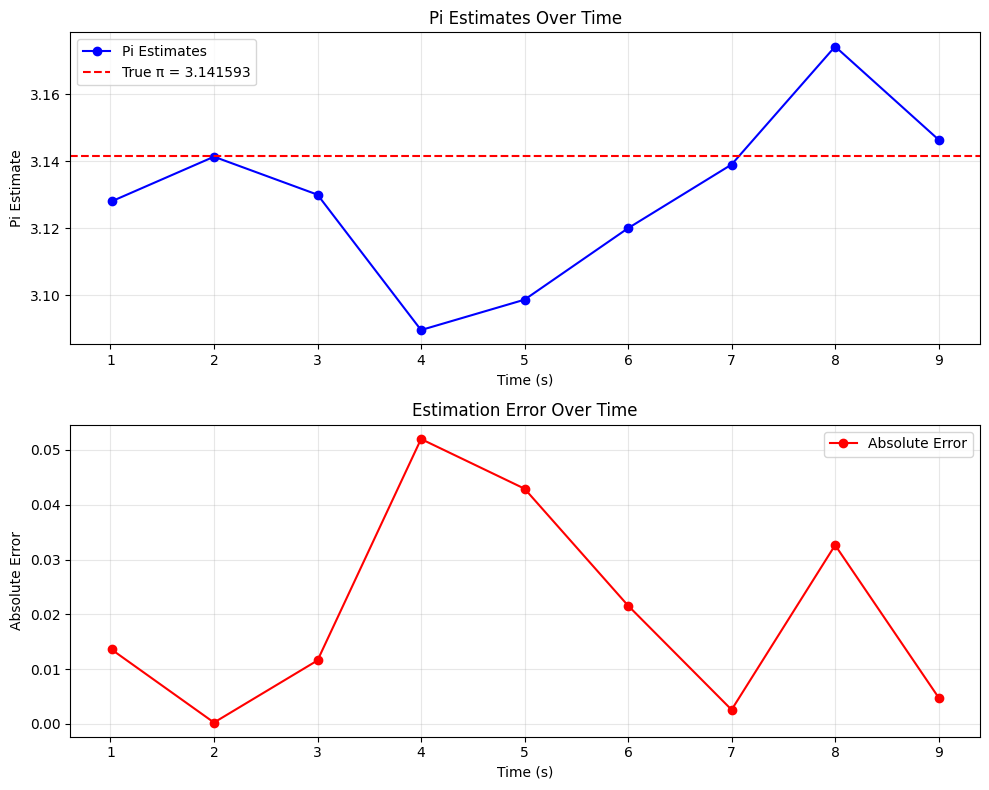


✓ Results analysis complete
Graph saved as 'pi_cosimulation_results.png'

=== Co-Simulation Complete ===


In [6]:
def run_pi_exchange_cosimulation():
    """
    Run the complete Pi exchange co-simulation with broker and federates
    """
    
    print("=== Starting Pi Exchange Co-Simulation ===")
    
    # Step 1: Create and start broker
    print("Creating HELICS broker...")
    broker = h.helicsCreateBroker("zmq", "", "-f 2 --name=mainbroker")
    
    # Verify broker is connected
    if h.helicsBrokerIsConnected(broker):
        print("✓ Broker created and connected successfully")
    else:
        print("✗ Broker connection failed")
        return
    
    # Step 2: Create queue for results
    results_queue = Queue()
    
    # Step 3: Create and start federate threads
    print("\nStarting federates...")
    
    # Start calculator federate thread
    calc_thread = threading.Thread(target=pi_calculator_federate)
    calc_thread.start()
    
    # Small delay to ensure calculator starts first
    time.sleep(0.5)
    
    # Start receiver federate thread
    recv_thread = threading.Thread(target=pi_receiver_federate, args=(results_queue,))
    recv_thread.start()
    
    # Step 4: Wait for federates to complete
    print("\nWaiting for federates to complete...")
    calc_thread.join(timeout=30)  # 30 second timeout
    recv_thread.join(timeout=30)
    
    # Step 5: Clean up broker
    h.helicsBrokerDestroy(broker)
    print("\n✓ Broker destroyed")
    
    # Step 6: Analyze results
    if not results_queue.empty():
        received_values = results_queue.get()
        analyze_pi_results(received_values)
    
    print("\n=== Co-Simulation Complete ===")

# Run the co-simulation
run_pi_exchange_cosimulation()

## Enhanced Example: Temperature Control System

Now we'll implement a more realistic example that demonstrates bidirectional communication: a temperature control system with a controller and a plant model.

### System Design

**Controller Federate:**
- Implements a simple PID-style temperature controller
- Subscribes to temperature measurements from the plant
- Publishes control signals (heating/cooling commands)
- Maintains setpoint temperature

**Plant Federate:**
- Models a simple thermal system with first-order dynamics
- Subscribes to control signals from the controller
- Publishes current temperature measurements
- Includes thermal disturbances and realistic dynamics

In [7]:
class SimpleController:
    """
    Simple proportional controller for temperature regulation
    """
    
    def __init__(self, setpoint=25.0, kp=2.0):
        self.setpoint = setpoint  # Desired temperature (°C)
        self.kp = kp              # Proportional gain
        self.last_error = 0.0
    
    def calculate_control_signal(self, measured_temperature):
        """
        Calculate control signal based on temperature error
        """
        error = self.setpoint - measured_temperature
        control_signal = self.kp * error
        
        # Limit control signal to realistic range (-100 to +100 watts)
        control_signal = max(-100, min(100, control_signal))
        
        return control_signal

class SimplePlant:
    """
    Simple thermal plant model with first-order dynamics
    """
    
    def __init__(self, initial_temp=20.0, time_constant=10.0, ambient_temp=18.0):
        self.temperature = initial_temp  # Current temperature (°C)
        self.time_constant = time_constant  # Thermal time constant (seconds)
        self.ambient_temp = ambient_temp    # Ambient temperature (°C)
        self.thermal_mass = 1.0            # Simplified thermal mass
    
    def update_temperature(self, control_signal, dt=1.0):
        """
        Update temperature based on control signal and thermal dynamics
        """
        # Heat loss to ambient
        heat_loss = (self.temperature - self.ambient_temp) / self.time_constant
        
        # Heat input from control system (watts to temperature change)
        heat_input = control_signal * 0.1  # Simplified heat transfer coefficient
        
        # Temperature change using simple Euler integration
        temp_change = (heat_input - heat_loss) * dt
        self.temperature += temp_change
        
        return self.temperature

print("✓ Controller and Plant classes defined")

✓ Controller and Plant classes defined


### Controller Federate Implementation

In [8]:
def temperature_controller_federate(results_queue):
    """
    HELICS federate implementing temperature controller
    """
    
    print("[Controller] Starting temperature controller federate...")
    
    # Create controller instance
    controller = SimpleController(setpoint=25.0, kp=2.0)
    
    # Create federate
    fedinfo = h.helicsCreateFederateInfo()
    h.helicsFederateInfoSetCoreName(fedinfo, "TemperatureController")
    h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
    h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
    h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.01)
    
    fed = h.helicsCreateValueFederate("TemperatureController", fedinfo)
    print("[Controller] ✓ Federate created")
    
    # Register publication (control signal output)
    control_pub = h.helicsFederateRegisterGlobalPublication(fed, "control_signal", h.HELICS_DATA_TYPE_DOUBLE, "")
    
    # Register subscription (temperature measurement input)
    temp_sub = h.helicsFederateRegisterSubscription(fed, "temperature_measurement", "")
    
    print("[Controller] ✓ Publications and subscriptions registered")
    
    # Enter execution mode
    h.helicsFederateEnterExecutingMode(fed)
    print("[Controller] ✓ Entering execution mode")
    
    # Main control loop
    simulation_data = []
    current_time = 0.0
    time_step = 1.0
    
    for step in range(30):  # Run for 30 seconds
        # Request next time step
        next_time = (step + 1) * time_step
        current_time = h.helicsFederateRequestTime(fed, next_time)
        
        # Get temperature measurement
        measured_temp = 20.0  # Default initial temperature
        if h.helicsInputIsUpdated(temp_sub):
            measured_temp = h.helicsInputGetDouble(temp_sub)
        
        # Calculate control signal
        control_signal = controller.calculate_control_signal(measured_temp)
        
        # Publish control signal
        h.helicsPublicationPublishDouble(control_pub, control_signal)
        
        # Log data
        error = controller.setpoint - measured_temp
        simulation_data.append({
            'time': current_time,
            'temperature': measured_temp,
            'setpoint': controller.setpoint,
            'control_signal': control_signal,
            'error': error
        })
        
        print(f"[Controller] Time {current_time:2.0f}s: T={measured_temp:5.1f}°C, SP={controller.setpoint:.1f}°C, U={control_signal:6.1f}W, E={error:5.1f}°C")
    
    # Store results
    results_queue.put(('controller', simulation_data))
    
    # Finalize
    h.helicsFederateDestroy(fed)
    print("[Controller] ✓ Federate finalized")

### Plant Federate Implementation

In [9]:
def analyze_temperature_control_results(results_queue):
    """
    Analyze and visualize temperature control results
    """
    
    # Collect results from both federates
    controller_data = None
    plant_data = None
    
    while not results_queue.empty():
        federate_type, data = results_queue.get()
        if federate_type == 'controller':
            controller_data = data
        elif federate_type == 'plant':
            plant_data = data
    
    if not controller_data or not plant_data:
        print("Insufficient data for analysis")
        return
    
    print("\n=== Temperature Control Analysis ===")
    
    # Extract time series data
    times = [item['time'] for item in controller_data]
    temperatures = [item['temperature'] for item in controller_data]
    setpoints = [item['setpoint'] for item in controller_data]
    control_signals = [item['control_signal'] for item in controller_data]
    errors = [item['error'] for item in controller_data]
    
    # Performance metrics
    settling_time = None
    steady_state_error = abs(errors[-1])
    max_overshoot = max([temp - setpoint for temp, setpoint in zip(temperatures, setpoints)])
    
    # Find settling time (within 2% of setpoint)
    tolerance = 0.02 * setpoints[0]
    for i, error in enumerate(errors):
        if abs(error) < tolerance and all(abs(e) < tolerance for e in errors[i:]):
            settling_time = times[i]
            break
    
    print(f"Steady-state error: {steady_state_error:.2f}°C")
    print(f"Maximum overshoot: {max_overshoot:.2f}°C")
    print(f"Settling time: {settling_time:.0f}s" if settling_time else "System did not settle within simulation time")
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Temperature vs setpoint
    ax1.plot(times, temperatures, 'b-', linewidth=2, label='Temperature')
    ax1.plot(times, setpoints, 'r--', linewidth=2, label='Setpoint')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Temperature Control Response')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Control signal
    ax2.plot(times, control_signals, 'g-', linewidth=2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Control Signal (W)')
    ax2.set_title('Controller Output')
    ax2.grid(True, alpha=0.3)
    
    # Temperature error
    ax3.plot(times, errors, 'r-', linewidth=2)
    ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Error (°C)')
    ax3.set_title('Temperature Error')
    ax3.grid(True, alpha=0.3)
    
    # Phase plot (temperature vs control signal)
    ax4.plot(control_signals, temperatures, 'b-', alpha=0.7)
    ax4.scatter(control_signals[0], temperatures[0], color='green', s=100, label='Start', zorder=5)
    ax4.scatter(control_signals[-1], temperatures[-1], color='red', s=100, label='End', zorder=5)
    ax4.set_xlabel('Control Signal (W)')
    ax4.set_ylabel('Temperature (°C)')
    ax4.set_title('Phase Plot')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('temperature_control_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Temperature control analysis complete")
    print("Graph saved as 'temperature_control_results.png'")

### Temperature Control Results Analysis

In [10]:
def temperature_plant_federate(results_queue):
    """
    HELICS federate implementing thermal plant model
    """
    
    print("[Plant] Starting thermal plant federate...")
    
    # Create plant instance
    plant = SimplePlant(initial_temp=20.0, time_constant=10.0, ambient_temp=18.0)
    
    # Create federate
    fedinfo = h.helicsCreateFederateInfo()
    h.helicsFederateInfoSetCoreName(fedinfo, "ThermalPlant")
    h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
    h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
    h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.01)
    
    fed = h.helicsCreateValueFederate("ThermalPlant", fedinfo)
    print("[Plant] ✓ Federate created")
    
    # Register publication (temperature measurement output)
    temp_pub = h.helicsFederateRegisterGlobalPublication(fed, "temperature_measurement", h.HELICS_DATA_TYPE_DOUBLE, "")
    
    # Register subscription (control signal input)
    control_sub = h.helicsFederateRegisterSubscription(fed, "control_signal", "")
    
    print("[Plant] ✓ Publications and subscriptions registered")
    
    # Enter execution mode
    h.helicsFederateEnterExecutingMode(fed)
    print("[Plant] ✓ Entering execution mode")
    
    # Publish initial temperature
    h.helicsPublicationPublishDouble(temp_pub, plant.temperature)
    
    # Main simulation loop
    simulation_data = []
    current_time = 0.0
    time_step = 1.0
    
    for step in range(30):  # Run for 30 seconds
        # Request next time step
        next_time = (step + 1) * time_step
        current_time = h.helicsFederateRequestTime(fed, next_time)
        
        # Get control signal
        control_signal = 0.0  # Default no control
        if h.helicsInputIsUpdated(control_sub):
            control_signal = h.helicsInputGetDouble(control_sub)
        
        # Update plant dynamics
        new_temperature = plant.update_temperature(control_signal, dt=time_step)
        
        # Publish temperature measurement
        h.helicsPublicationPublishDouble(temp_pub, new_temperature)
        
        # Log data
        simulation_data.append({
            'time': current_time,
            'temperature': new_temperature,
            'control_signal': control_signal
        })
        
        print(f"[Plant] Time {current_time:2.0f}s: T={new_temperature:5.1f}°C, U={control_signal:6.1f}W")
    
    # Store results
    results_queue.put(('plant', simulation_data))
    
    # Finalize
    h.helicsFederateDestroy(fed)
    print("[Plant] ✓ Federate finalized")

### Running the Temperature Control Co-Simulation

=== Starting Temperature Control Co-Simulation ===
✓ Broker created and connected

Starting federates...
[Plant] Starting thermal plant federate...
[Plant] ✓ Federate created
[Plant] ✓ Publications and subscriptions registered
[Controller] Starting temperature controller federate...

Waiting for federates to complete...
[Controller] ✓ Federate created
[Controller] ✓ Publications and subscriptions registered
[Plant] ✓ Entering execution mode
[Controller] ✓ Entering execution mode
[Controller] Time  0s: T= 20.0°C, SP=25.0°C, U=  10.0W, E=  5.0°C
[Plant] Time  0s: T= 20.8°C, U=  10.0W
[Controller] Time  0s: T= 20.8°C, SP=25.0°C, U=   8.4W, E=  4.2°C
[Plant] Time  0s: T= 21.4°C, U=   8.4W
[Controller] Time  0s: T= 21.4°C, SP=25.0°C, U=   7.3W, E=  3.6°C
[Plant] Time  3s: T= 21.0°C, U=   0.0W
[Plant] Time  3s: T= 21.4°C, U=   7.3W
[Controller] Time  3s: T= 21.0°C, SP=25.0°C, U=   8.0W, E=  4.0°C
[Controller] Time  3s: T= 21.4°C, SP=25.0°C, U=   7.1W, E=  3.6°C
[Plant] Time  3s: T= 21.9°C, U

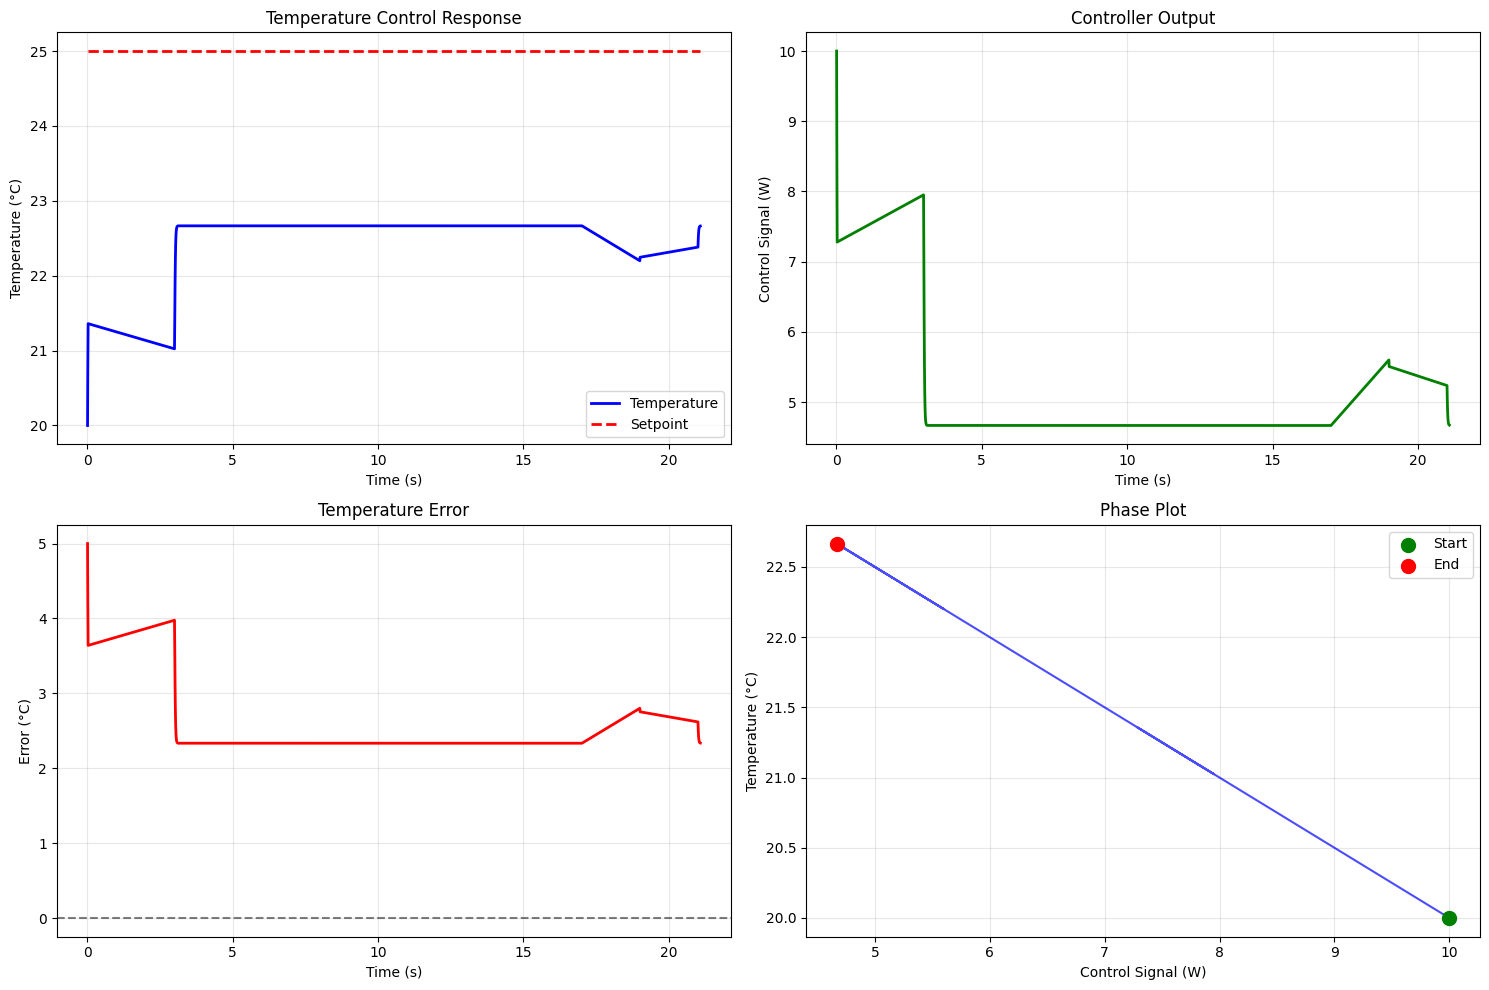


✓ Temperature control analysis complete
Graph saved as 'temperature_control_results.png'

=== Temperature Control Co-Simulation Complete ===


In [11]:
def run_temperature_control_cosimulation():
    """
    Run the complete temperature control co-simulation
    """
    
    print("=== Starting Temperature Control Co-Simulation ===")
    
    # Create broker
    broker = h.helicsCreateBroker("zmq", "", "-f 2 --name=tempbroker")
    
    if h.helicsBrokerIsConnected(broker):
        print("✓ Broker created and connected")
    else:
        print("✗ Broker connection failed")
        return
    
    # Create results queue
    results_queue = Queue()
    
    # Start federates
    print("\nStarting federates...")
    
    # Start plant federate first (it publishes initial temperature)
    plant_thread = threading.Thread(target=temperature_plant_federate, args=(results_queue,))
    plant_thread.start()
    
    time.sleep(0.5)  # Brief delay
    
    # Start controller federate
    controller_thread = threading.Thread(target=temperature_controller_federate, args=(results_queue,))
    controller_thread.start()
    
    # Wait for completion
    print("\nWaiting for federates to complete...")
    plant_thread.join(timeout=60)
    controller_thread.join(timeout=60)
    
    # Clean up
    h.helicsBrokerDestroy(broker)
    print("\n✓ Broker destroyed")
    
    # Analyze results
    analyze_temperature_control_results(results_queue)
    
    print("\n=== Temperature Control Co-Simulation Complete ===")

# Run the temperature control co-simulation
run_temperature_control_cosimulation()

## JSON Configuration Alternative

While we've been configuring federates programmatically, HELICS also supports JSON configuration files for cleaner separation of configuration and implementation logic.

### Example JSON Configuration

:::{admonition} Not working
:class: warning

The example is not working and needs fixing.

:::

In [12]:
# Create example JSON configuration files
import json

# Controller configuration
controller_config = {
    "name": "TemperatureController",
    "core_type": "zmq",
    "core_init_string": "--federates=1",
    "period": 1.0,
    "publications": [
        {
            "key": "control_signal",
            "type": "double",
            "global": True,
            "info": "Control signal output in watts"
        }
    ],
    "subscriptions": [
        {
            "key": "temperature_measurement",
            "type": "double",
            "info": "Temperature measurement input in Celsius"
        }
    ]
}

# Plant configuration
plant_config = {
    "name": "ThermalPlant",
    "autobroker": True,
    "coreType": "zmq",
    "coreInit": "--federates=1",
    "period": 1.0,
    "publications": [
        {
            "key": "temperature_measurement",
            "type": "double",
            "global": True,
            "info": "Temperature measurement output in Celsius"
        }
    ],
    "subscriptions": [
        {
            "key": "control_signal",
            "type": "double",
            "info": "Control signal input in watts"
        }
    ]
}

# Save configuration files
with open('controller_config.json', 'w') as f:
    json.dump(controller_config, f, indent=2)

with open('plant_config.json', 'w') as f:
    json.dump(plant_config, f, indent=2)

print("✓ JSON configuration files created")
print("  - controller_config.json")
print("  - plant_config.json")

✓ JSON configuration files created
  - controller_config.json
  - plant_config.json


### Using JSON Configuration

Here's how to use JSON configuration instead of programmatic setup:

In [ ]:
def create_federate_from_json(config_file):
    """
    Demonstrate creating a federate from JSON configuration
    """
    
    print(f"Creating federate from {config_file}...")
    
    try:
        # Create federate from JSON config
        fed = h.helicsCreateValueFederateFromConfig(config_file)
        
        # Get federate name from configuration
        fed_name = h.helicsFederateGetName(fed)
        print(f"✓ Federate '{fed_name}' created successfully from JSON")
        
        # Clean up (don't actually run)
        h.helicsFederateDestroy(fed)
        
    except Exception as e:
        print(f"✗ Failed to create federate from JSON: {e}")

# Demonstrate JSON configuration usage
create_federate_from_json('controller_config.json')
create_federate_from_json('plant_config.json')

Creating federate from controller_config.json...
[2025-07-23 03:17:14.531] [console] [warning] commWarning||TemperatureController_core_7YnjtS (0)[connecting]::zmq broker connection timed out, trying again (2)
[2025-07-23 03:17:14.532] [console] [warning] commWarning||TemperatureController_core_7YnjtS (0)[connecting]::sending message to tcp://127.0.0.1:23405


## Debugging and Troubleshooting

### Common Issues and Solutions

Understanding how to debug HELICS co-simulations is essential for successful implementation. Due to the distributed nature, debugging co-simulation code is usually more complex than debugging individual scripts.

In [ ]:
def helics_diagnostic_check():
    """
    Comprehensive diagnostic check for HELICS functionality
    """
    
    print("=== HELICS Diagnostic Check ===")
    
    # Check 1: HELICS import and version
    try:
        import helics as h
        version = h.helicsGetVersion()
        print(f"✓ HELICS {version} imported successfully")
    except ImportError as e:
        print(f"✗ HELICS import failed: {e}")
        print("  Solution: Ensure 'cosim' environment is activated and HELICS is installed")
        return False
    
    # Check 2: Broker creation and connection
    try:
        broker = h.helicsCreateBroker("zmq", "", "-f 1 --name=diagnostic")
        if h.helicsBrokerIsConnected(broker):
            print("✓ Broker creation and connection successful")
            h.helicsBrokerDestroy(broker)
        else:
            print("✗ Broker created but not connected")
            print("  Solution: Check network configuration and port availability")
            return False
    except Exception as e:
        print(f"✗ Broker creation failed: {e}")
        print("  Solution: Check ZMQ installation and system resources")
        return False
    
    # Check 3: Federate creation
    try:
        fedinfo = h.helicsCreateFederateInfo()
        h.helicsFederateInfoSetCoreName(fedinfo, "DiagnosticTest")
        h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
        
        fed = h.helicsCreateValueFederate("DiagnosticTest", fedinfo)
        print("✓ Federate creation successful")
        h.helicsFederateDestroy(fed)
    except Exception as e:
        print(f"✗ Federate creation failed: {e}")
        print("  Solution: Check federate configuration and broker availability")
        return False
    
    # Check 4: Publication/Subscription registration
    try:
        fedinfo = h.helicsCreateFederateInfo()
        fed = h.helicsCreateValueFederate("DiagnosticTest2", fedinfo)
        
        pub = h.helicsFederateRegisterGlobalPublication(fed, "test_pub", h.HELICS_DATA_TYPE_DOUBLE, "")
        sub = h.helicsFederateRegisterSubscription(fed, "test_sub", "")
        
        print("✓ Publication/Subscription registration successful")
        h.helicsFederateDestroy(fed)
    except Exception as e:
        print(f"✗ Pub/Sub registration failed: {e}")
        print("  Solution: Check publication/subscription names and types")
        return False
    
    print("\n✅ All diagnostic checks passed!")
    return True

# Run diagnostic check
helics_diagnostic_check()

### Common Error Scenarios and Solutions

**1. Broker Connection Failures**
- **Symptoms**: Federates hang during creation or entering execution mode
- **Causes**: Network issues, port conflicts, incorrect broker configuration
- **Solutions**: Restart broker, check port availability, verify network settings

**2. Time Synchronization Issues**
- **Symptoms**: Federates advance at different rates, simulation hangs
- **Causes**: Incorrect time delta settings, missing time requests
- **Solutions**: Verify time request logic, check time delta configuration

**3. Publication/Subscription Mismatches**
- **Symptoms**: No data exchange, incorrect values received
- **Causes**: Name mismatches, type incompatibilities, timing issues
- **Solutions**: Verify names and types, check update flags

**4. Federate Execution Hangs**
- **Symptoms**: Federates stop responding, infinite waits
- **Causes**: Missing federates, incorrect execution mode entry
- **Solutions**: Ensure all federates enter execution mode, implement timeouts

### Best Practices for HELICS Development

1. **Start Simple**: Begin with minimal examples and add complexity gradually
2. **Use Descriptive Names**: Clear publication and subscription names prevent confusion
3. **Implement Timeouts**: Prevent infinite hangs with appropriate timeouts
4. **Log Extensively**: Use print statements or logging to track federate behavior
5. **Test Incrementally**: Verify each component before integration
6. **Handle Errors Gracefully**: Implement proper error handling and cleanup

## Hands-On Exercise: Data Logger Federate

Now it's time to apply what we've learned. We'll extend our temperature control system by adding a third federate that logs data from both the controller and plant.

### Exercise Requirements

Create a **Data Logger Federate** that:
1. Subscribes to both temperature measurements and control signals
2. Logs all data to a CSV file with timestamps
3. Calculates and displays real-time statistics
4. Creates a summary report at the end of simulation

### Implementation Template

Complete the missing parts in the template below:

In [ ]:
import csv

def data_logger_federate():
    """
    HELICS federate that logs data from temperature control system
    
    TODO: Complete this implementation
    """
    
    print("[Logger] Starting data logger federate...")
    
    # TODO 1: Create federate (similar to previous examples)
    fedinfo = h.helicsCreateFederateInfo()
    # Add your federate configuration here
    
    fed = h.helicsCreateValueFederate("DataLogger", fedinfo)
    print("[Logger] ✓ Federate created")
    
    # TODO 2: Register subscriptions for temperature and control signal
    temp_sub = None  # Subscribe to "temperature_measurement"
    control_sub = None  # Subscribe to "control_signal"
    
    # TODO 3: Enter execution mode
    # Add code here
    
    # TODO 4: Create CSV file for logging
    csv_filename = "temperature_control_log.csv"
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['time', 'temperature', 'control_signal']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        # TODO 5: Main logging loop (30 time steps)
        current_time = 0.0
        time_step = 1.0
        logged_data = []
        
        for step in range(30):
            # TODO: Request next time step
            
            # TODO: Get temperature and control signal values
            temperature = 0.0
            control_signal = 0.0
            
            # Log data
            data_point = {
                'time': current_time,
                'temperature': temperature,
                'control_signal': control_signal
            }
            
            writer.writerow(data_point)
            logged_data.append(data_point)
            
            print(f"[Logger] Time {current_time:2.0f}s: Logged T={temperature:5.1f}°C, U={control_signal:6.1f}W")
    
    # TODO 6: Generate summary statistics
    if logged_data:
        temperatures = [d['temperature'] for d in logged_data]
        control_signals = [d['control_signal'] for d in logged_data]
        
        print("\n[Logger] === Summary Statistics ===")
        print(f"Temperature: min={min(temperatures):.1f}, max={max(temperatures):.1f}, avg={sum(temperatures)/len(temperatures):.1f}°C")
        print(f"Control: min={min(control_signals):.1f}, max={max(control_signals):.1f}, avg={sum(control_signals)/len(control_signals):.1f}W")
    
    # TODO 7: Finalize federate
    # Add cleanup code here
    
    print(f"[Logger] ✓ Data logged to {csv_filename}")
    print("[Logger] ✓ Federate finalized")

print("✓ Data logger template created")
print("Complete the TODO items to implement the data logger federate")

### Exercise Solution

Here's the complete implementation of the data logger federate:

In [ ]:
def data_logger_federate_solution():
    """
    Complete implementation of data logger federate
    """
    
    print("[Logger] Starting data logger federate...")
    
    # Create federate
    fedinfo = h.helicsCreateFederateInfo()
    h.helicsFederateInfoSetCoreName(fedinfo, "DataLogger")
    h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
    h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
    h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.01)
    
    fed = h.helicsCreateValueFederate("DataLogger", fedinfo)
    print("[Logger] ✓ Federate created")
    
    # Register subscriptions
    temp_sub = h.helicsFederateRegisterSubscription(fed, "temperature_measurement", "")
    control_sub = h.helicsFederateRegisterSubscription(fed, "control_signal", "")
    print("[Logger] ✓ Subscriptions registered")
    
    # Enter execution mode
    h.helicsFederateEnterExecutingMode(fed)
    print("[Logger] ✓ Entering execution mode")
    
    # Create CSV file for logging
    csv_filename = "temperature_control_log.csv"
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['time', 'temperature', 'control_signal']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        # Main logging loop
        current_time = 0.0
        time_step = 1.0
        logged_data = []
        
        for step in range(30):
            # Request next time step
            next_time = (step + 1) * time_step
            current_time = h.helicsFederateRequestTime(fed, next_time)
            
            # Get temperature measurement
            temperature = 20.0  # Default value
            if h.helicsInputIsUpdated(temp_sub):
                temperature = h.helicsInputGetDouble(temp_sub)
            
            # Get control signal
            control_signal = 0.0  # Default value
            if h.helicsInputIsUpdated(control_sub):
                control_signal = h.helicsInputGetDouble(control_sub)
            
            # Log data
            data_point = {
                'time': current_time,
                'temperature': temperature,
                'control_signal': control_signal
            }
            
            writer.writerow(data_point)
            logged_data.append(data_point)
            
            print(f"[Logger] Time {current_time:2.0f}s: Logged T={temperature:5.1f}°C, U={control_signal:6.1f}W")
    
    # Generate summary statistics
    if logged_data:
        temperatures = [d['temperature'] for d in logged_data]
        control_signals = [d['control_signal'] for d in logged_data]
        
        print("\n[Logger] === Summary Statistics ===")
        print(f"Temperature: min={min(temperatures):.1f}, max={max(temperatures):.1f}, avg={sum(temperatures)/len(temperatures):.1f}°C")
        print(f"Control: min={min(control_signals):.1f}, max={max(control_signals):.1f}, avg={sum(control_signals)/len(control_signals):.1f}W")
    
    # Finalize federate
    h.helicsFederateDestroy(fed)
    
    print(f"[Logger] ✓ Data logged to {csv_filename}")
    print("[Logger] ✓ Federate finalized")

print("✓ Data logger solution implemented")
print("This federate can be integrated into the temperature control co-simulation")

## Summary and Key Takeaways

### What We've Learned

In this lesson, we've covered the fundamental concepts and practical implementation of HELICS co-simulation:

1. **Core Concepts**:
   - Brokers coordinate communication between federates
   - Federates are independent simulation entities
   - Publication/subscription model enables scalable data exchange
   - Time management ensures coordinated execution

2. **Implementation Skills**:
   - Creating and configuring HELICS federates
   - Implementing publication and subscription interfaces
   - Managing co-simulation execution and time synchronization
   - Using both programmatic and JSON configuration approaches

3. **Practical Examples**:
   - Pi exchange: Simple unidirectional communication
   - Temperature control: Bidirectional feedback system
   - Data logging: Multi-subscription federate design

4. **Debugging Skills**:
   - Common error identification and resolution
   - Diagnostic procedures for HELICS issues
   - Best practices for robust co-simulation development

### Preparation for Advanced Topics

The skills developed in this lesson provide the foundation for more advanced applications:

- **Power System Co-simulation**: Using HELICS to coordinate transmission and distribution simulators
- **Multi-Domain Modeling**: Integrating electrical, mechanical, thermal, and communication systems
- **Large-Scale Simulations**: Scaling to hundreds or thousands of federates
- **Real-Time Applications**: Hardware-in-the-loop and real-time co-simulation

### Next Steps

In the next lesson, we will apply these HELICS fundamentals to power system co-simulation, where we'll:
- Connect transmission system simulators (ANDES) with distribution system simulators (OpenDSS)
- Exchange power flow data between different voltage levels
- Analyze the interactions between transmission and distribution operations
- Understand the practical challenges of multi-domain power system simulation

### Self-Assessment

Before proceeding to the next lesson, ensure that:
- [ ] All code examples in this notebook execute successfully
- [ ] The diagnostic check passes without errors
- [ ] The temperature control co-simulation produces reasonable results
- [ ] The data logger exercise is completed successfully
- [ ] Key HELICS concepts are clearly understood

If any of these items are incomplete, review the relevant sections and seek assistance as needed.

## References and Additional Resources

### HELICS Documentation
- **Official Documentation**: https://docs.helics.org/
- **Python API Reference**: https://python.helics.org/
- **Tutorial Repository**: https://github.com/GMLC-TDC/HELICS-Tutorial

### Academic Papers
- Hardy, T. D., et al. "HELICS: A co-simulation framework for scalable multi-domain modeling and analysis." IEEE Access 12 (2024): 24325-24347.
- Top, P., et al. "The HELICS co-simulation framework." 2017 Workshop on Modeling and Simulation of Cyber-Physical Energy Systems (MSCPES). IEEE, 2017.

### Community Resources
- **HELICS Gitter Chat**: https://gitter.im/GMLC-TDC/HELICS
- **GitHub Issues**: https://github.com/GMLC-TDC/HELICS/issues
- **User Forum**: https://github.com/GMLC-TDC/HELICS/discussions